In [1]:
#Dataset path
PATH = 'datasets/'

import collections
import pandas as pd
import numpy as np
import scipy.stats as stats
from sklearn.decomposition import PCA

# data visualizations
import seaborn as sns
sns.set(font_scale=1.5, style='whitegrid')
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse
import matplotlib.patches as mpatches
from IPython.display import display, clear_output

from tf.app import use

In [2]:
A = use('bhsa', hoist=globals(), mod='etcbc/heads/tf')

TF app is up-to-date.
Using annotation/app-bhsa commit 5fdf1778d51d938bfe80b37b415e36618e50190c (=latest)
  in C:\Users\Ejer/text-fabric-data/__apps__/bhsa.
Using etcbc/bhsa/tf - c r1.4 in C:\Users\Ejer/text-fabric-data
Using etcbc/phono/tf - c r1.1 in C:\Users\Ejer/text-fabric-data
Using etcbc/parallels/tf - c r1.1 in C:\Users\Ejer/text-fabric-data
Using etcbc/heads/tf - c rv.1.11 in C:\Users\Ejer/text-fabric-data


### Basic functions

In [3]:
def reverse_hb(hb_text):
    return ''.join(reversed(hb_text))

def simple_bar(dic, sort=True):
    df = pd.DataFrame([dic]).T
    if sort:
        df = df.sort_values(by=0, ascending=False)
    
    plt.bar(x=df.index, height=df.loc[:,0])
    plt.show()
    
def createDF(query_results, loc_verb, loc_constr='', name_constr=''):    
    if name_constr:
        constr = name_constr
    
    verb_constr = collections.defaultdict(lambda: collections.Counter())
    for r in query_results:
        verb_gloss = F.gloss.v(L.u(r[loc_verb], 'lex')[0])
        disambig = ''.join(letter for letter in F.lex.v(r[loc_verb]) if letter in {'=', '/', '['})
        verb_str = verb_gloss+disambig

        if loc_constr:
            if F.otype.v(r[loc_constr]) == 'word':
                constr = F.lex_utf8.v(r[loc_constr])
            else:
                constr = r[loc_constr]
        
        verb_constr[constr][verb_str] += 1
        
    df = pd.DataFrame(verb_constr).fillna(0)
    
    return df

### Preparing corpus

In [4]:
# prepare the corpus

corpus = [book for book in F.otype.s('book') if book < T.nodeFromSection(('Isaiah',))]
print('Corpus:\n')
print('\n'.join(T.sectionFromNode(book)[0] for book in corpus))

Corpus:

Genesis
Exodus
Leviticus
Numbers
Deuteronomy
Joshua
Judges
1_Samuel
2_Samuel
1_Kings
2_Kings


In [5]:
sets={'corpus':corpus} # make set for searching

## Overall statistics

We will explore *Qal* verbs and their collocations with certain complements.

In [6]:
Qal = '''
corpus
 clause
  phrase function=Pred|PreO|PreS
    word vs=qal
'''

unique_verbs = set()

for r in A.search(Qal, sets=sets, silent=True):
    unique_verbs.add(F.lex.v(r[3]))
    
print(f'Number of verbs in Qal and functioning as predicate: {len(unique_verbs)}')

Number of verbs in Qal and functioning as predicate: 646


How many Qal-verbs with complements?

In [7]:
Qal_cmpl = '''
corpus
 clause
  phrase function=Pred|PreO|PreS
    word vs=qal
  phrase function=Cmpl
'''

unique_verbs_cmpl = set()

for r in A.search(Qal_cmpl, sets=sets, silent=True):
    unique_verbs_cmpl.add(F.lex.v(r[3]))
    
print(f'Number of verbs in Qal with complement: {len(unique_verbs_cmpl)}')

Number of verbs in Qal with complement: 430


That is, 216 verb lexemes are not accounted for by this analysis. Those lexemes may have other significant modifiers, such as time and locative phrases. 

In [8]:
len(unique_verbs)-len(unique_verbs_cmpl)

216

## Breaking down complements phrases:

In [9]:
complements = '''
corpus
  clause
    phrase function=Pred|PreO|PreS
      word vs=qal sp=verb
    phrase function=Cmpl
'''
complements = A.search(complements, sets=sets)

  2.17s 10081 results


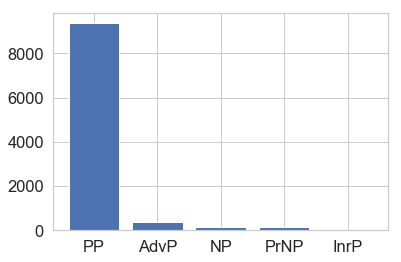

In [10]:
complement_types = collections.defaultdict(int)

for r in complements:
    complement_types[F.typ.v(r[4])] += 1
    
simple_bar(complement_types)

### Zooming in on Prepositional Phrases

In [11]:
PP  = '''
corpus
  clause
    phrase function=Cmpl typ=PP
    phrase function=Pred|PreO|PreS
      word sp=verb vs=qal
'''

PP = A.search(PP, sets=sets)

  2.09s 9364 results


In [12]:
PP_sp = collections.defaultdict(int)

for r in PP:
    head = E.head.t(r[2])[0]
    PP_sp[F.sp.v(head)] += 1

PP_sp

defaultdict(int, {'prep': 9069, 'subs': 295})

Prepositions:

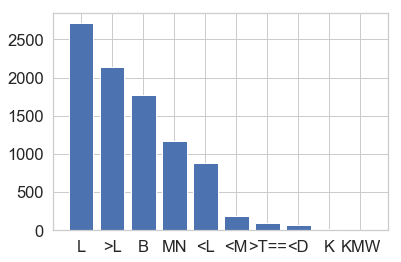

In [13]:
prep_dict = collections.defaultdict(int)

for r in PP:
    head = E.head.t(r[2])[0]
    if F.sp.v(head) == 'prep':
        prep_dict[F.lex.v(head)] += 1
        
simple_bar(prep_dict)

### Exploring prepositions

We will explore the prepositions in some depth, because the prepositions are polysemous and can be used in many different functions. One way to avoid cases that do not have a prototypical spatial meaning is to walk through the nouns governed by these prepositions. Proper nouns and nouns denoting animate entities (such as אישׂ "man") are retained because we can expect those types to function as datives, directions or locations.

In contrast, nouns that denote physical objects or body parts are removed because they can also be instruments. These nouns are added to a stop list containing nouns to be avoided in the analysis:

In [14]:
stoplist = set()

The following query is the default query to explore the prepositions one by one:

In [15]:
query = '''
corpus
  clause
    phrase function=Cmpl
      =: word lex={}
    phrase function=Pred|PreO|PreS
      word sp=verb vs=qal
'''

### ל

ל is used in a great variety of ways. One of the basic senses is locative (cf. BHRG §11.2.10b), but the preposition may mark either position or direction, depending on the verb, making, in effect, the preposition very versatile. For that reason, the preposition is not a good indicator as to whether the verb is stative or active.

### אל

אל is used for a varity of expressions, typically denoting either direction or dative, e.g. recipient or addressee, but also ethical dative and comitative (cf. BHRG §11.2.2a). We will take a look at those nouns governed by the preposition to sort out clearly locative senses:

In [16]:
EL = A.search(query.format('>L'), sets=sets)
A.show(EL, end=1)

  3.13s 2129 results


A great number of cases is found, and we will explore the substantives governed by the prepositions and occuring at least five times in this construction:

In [17]:
EL_obj = collections.Counter()

for r in EL:
    obj = E.obj_prep.t(r[3])
    if len(obj) > 0:
        EL_obj[F.lex.v(obj[0])] += 1
        
EL_obj = pd.DataFrame(EL_obj, index=['count']).T.sort_values(by='count', ascending=False)

To automize matters we define a function that creates a subset of the dataframe constrained by a minimum count (5) and the stoplist: 

In [18]:
def getNouns(df, min_count=5, stoplist=stoplist):
    return df[(df.loc[:,'count'] >= 5) & ~df.index.isin(stoplist)]

getNouns(EL_obj)

,count
MCH=/,94
MLK/,79
JHWH/,59
DWD==/,50
>RY/,49
BJT/,48
<M/,38
BN/,31
C>WL=/,29
<JR/,27


The majority of these nouns is proper nouns, and we cannot know whether the proper nouns are used as directional ("to someone") or dative ("for someone"), clearly denoting an activity, or whether they are used as comatitative ("with someone") that could be used with both stative and active verbs. We will retain these words but delete other words that are less likely as indicating a spatial event.

We will explore מים "water" in more details because it can be a place or a physical object:

In [19]:
MJM = '''
corpus
  clause
    phrase function=Cmpl
      =: word lex=>L
      <obj_prep- word lex=MJM/
    phrase function=Pred|PreO|PreS|PtcO
      word sp=verb vs=qal
'''

MJM = A.search(MJM, sets=sets)
A.show(MJM)

  3.22s 5 results


"Water" is used in different ways in these 5 cases. In three cases it refers to a location of a sea or a lake, while in two cases it is water as a physical object, similar to, e.g., "fire", or "dust". We will remove מים from our list:

In [20]:
stoplist.add('MJM/')

Also קדשׁ is dubious, as it can mean sanctuary (a place) or holy gifts (objects). We will take a closer look at those eight cases:

In [21]:
QDC = '''
corpus
  clause
    phrase function=Cmpl
      =: word lex=>L
      <obj_prep- word lex=QDC/
    phrase function=Pred|PreO|PreS|PtcO
      word sp=verb vs=qal
'''

QDC = A.search(QDC, sets=sets)
A.show(QDC)

  3.31s 8 results


In all of these cases קדשׁ denotes the sanctuary as a physical space one can approach. Therefore we retain the word in the list.

In conclusion, we have retained nouns accounting for 1084 cases:

In [22]:
getNouns(EL_obj).sum()

count    1089
dtype: int64

A number of cases have been deleted, primarily due to the restrictions of minimum occurences of 5 cases per noun:

In [23]:
prep_dict['>L']-getNouns(EL_obj).sum()

count    1047
dtype: int64

###  ב

The prepositions ב is used both as locative ("in", "by", "at"), but also as instrument ("with"). To distinguish these senses, we take a closer look at the nouns governed by the preposition:

In [24]:
B = A.search(query.format('B'), sets=sets)

  2.80s 1769 results


In [25]:
B_obj = collections.Counter()

for r in B:
    obj = E.obj_prep.t(r[3])
    if len(obj) > 0:
        B_obj[F.lex.v(obj[0])] += 1
        
B_obj = pd.DataFrame(B_obj, index=['count']).T.sort_values(by='count', ascending=False)

In [26]:
getNouns(B_obj)

,count
JD/,140
<JN/,91
>RY/,72
QWL/,66
DRK/,59
>C/,39
JRWCLM/,26
BJT/,25
JHWH/,25
MDBR/,22


Some of these nouns are not typically referring to a specific place, so they are removed:

In [27]:
stoplist.update(['JD/','<JN/','QWL/','MJM/','CWPR/','CM/','PH/','>BN/','MLXMH/','DM/','>ZN/','XQH/','KP/','LB/','DBR/',
                 'R>C/','LBB/','KL/','>P/'])

By removing these nouns, the total amount of noun occurences is considerably reduced:

In [28]:
getNouns(B_obj).sum().item()

524

In [29]:
len(B)-getNouns(B_obj).sum().item()

1245

We now have 524 clauses out of 1776 possible, which is a reasonable proportion, given that 60% are generally considered spatial (BHRG, §39.6)

In [30]:
print(f'Proportion of ב prepositions: {round(getNouns(B_obj).sum().item()/prep_dict["B"]*100, 2)}%')

Proportion of ב prepositions: 29.5%


### מן

מן has both a spatial, a partial, and a comparative sense. Even the spatial sense is not easy to distinguish because it can refer to the origin of a movement or the direction where a thing is located (cf. BHRG, §11.2.11b). Therefore, we skip this preposition in the present analysis.

### על

The most commen sense of על is the spatial "on" or "over" (cf. BHRG §11.2.13b). Apart from this locative sense, על may less frequently be used as the goal of a movement. The preposition can also be used as denoting opposition ("against") or as marking a topic ("concerning"). As before, we will take a look at the nouns governed by the preposition: 

In [31]:
AL = A.search(query.format('<L'), sets=sets)

  2.76s 885 results


In [32]:
AL_obj = collections.Counter()

for r in AL:
    obj = E.obj_prep.t(r[3])
    if len(obj) > 0:
        AL_obj[F.lex.v(obj[0])] += 1
        
AL_obj = pd.DataFrame(AL_obj, index=['count']).T.sort_values(by='count', ascending=False)

In [33]:
getNouns(AL_obj)

,count
PNH/,33
JFR>L/,31
MZBX/,29
KS>/,20
>RY/,20
NPC/,13
<Y/,12
QRN/,9
<M/,9
YW>R/,8


The following words are removed because they refer to body parts:

In [34]:
stoplist.update(['KTP/','TNWK/','BRK/'])

Some words need further exploration:

In [35]:
ARWN = '''
corpus
  clause
    phrase function=Cmpl
      =: word lex=<L
      <obj_prep- word lex=>RWN/
    phrase function=Pred|PreO|PreS|PtcO
      word sp=verb vs=qal
'''

A.show(A.search(ARWN, sets=sets))

  2.91s 7 results


In most cases, על is used with ארון as a locative, except for 1 Sam 4:13 where the preposition should likely be translated "because of", therefore not a locative sense.

In [36]:
stoplist.add('>RWN/')

In [37]:
LWX = '''
corpus
  clause
    phrase function=Cmpl
      =: word lex=<L
      <obj_prep- word lex=LWX/
    phrase function=Pred|PreO|PreS|PtcO
      word sp=verb vs=qal
'''

A.show(A.search(LWX, sets=sets))

  2.90s 6 results


In all cases לוח "tablet" is used as an object *on which* something is written. It is therefore spatial.

In conclusion, we have 232 cases with על:

In [38]:
getNouns(AL_obj).sum().item()

232

654 cases have been deleted:

In [39]:
prep_dict['<L']-getNouns(AL_obj).sum().item()

654

### Final ה

The final-H construction is generally considered a construction of direction, e.g.: "... in coming to Gerah" or "... in direction of Gerah" (Gen 10:19):

In [40]:
final_h = '''
corpus
  clause
    phrase function=Cmpl
      word uvf=H
    phrase function=Pred|PreO|PreS|PtcO
      word sp=verb vs=qal
'''

final_h = A.search(final_h, sets=sets)
A.show(final_h, end=1)

  3.30s 344 results


In [41]:
final_h_df = createDF(final_h, name_constr='final H', loc_verb=5)

In [42]:
final_h_df.sort_values(by='final H', ascending=False)[:20]

,final H
come[,94
walk[,36
ascend[,28
pass[,22
descend[,20
flee[,20
go out[,18
fall[,17
return[,16
send[,12


### Summing up

We have generated a stoplist, comprising the following lexemes:

In [43]:
stoplist

{'<JN/',
 '>BN/',
 '>P/',
 '>RWN/',
 '>ZN/',
 'BRK/',
 'CM/',
 'CWPR/',
 'DBR/',
 'DM/',
 'JD/',
 'KL/',
 'KP/',
 'KTP/',
 'LB/',
 'LBB/',
 'MJM/',
 'MLXMH/',
 'PH/',
 'QWL/',
 'R>C/',
 'TNWK/',
 'XQH/'}

Moreover, we have chosen only to work with constructions occuring at least five times for each preposition. This restriction, along with the stoplist, reduces the relevant cases significantly:

In [44]:
constructions = [EL_obj, B_obj, AL_obj]

cases = sum([getNouns(c).sum().item() for c in constructions])
cases

1833

The accepted nouns are as follow:

In [45]:
accepted_nouns = set()

for c in constructions:
    nouns = getNouns(c)
    accepted_nouns.update(nouns.index)
    
len(accepted_nouns)

85

In [46]:
#accepted_nouns

The total number of constructions is:

In [47]:
sum_constr = sum(prep_dict.values())
sum_constr

9069

Accordingly, the proportion is:

In [48]:
print(f'{round(cases/sum_constr*100, 2)}%')

20.21%


Apart from these come cases with proper names.

## Verb collocations

We are now ready for computing the association strength between verbs and the chosen complement constructions

In [49]:
prepositions = ['>L','<L','B']

In [50]:
test_set = '''
corpus
  clause
    phrase function=Cmpl
    /with/
      =: word lex={preps}
      <obj_prep- word sp=nmpr
    /or/
      =: word lex={preps}
      <obj_prep- word lex={accepted_nouns}
    /or/
      word uvf=H
    /-/
    phrase function=Pred|PreO|PreS
      word sp=verb vs=qal
'''

result_test_set = A.search(test_set.format(preps='|'.join(prepositions), accepted_nouns='|'.join(accepted_nouns)), sets=sets)

  2.77s 2580 results


These results account for 28.45% of the relevant cases:

In [51]:
print(f'{round(len(result_test_set)/sum_constr*100, 2)}%')

28.45%


The next step is to extract the results and organize them in a dataframe with the frequencies of each construction (verb + complement construction). First, however, we need to map each preposition to a commonly known transcription:

In [52]:
prep_map = {'B': 'b',
           '>L':'ʾl',
           '<L':'ʿl'}

In [53]:
const_counts = collections.defaultdict(lambda: collections.Counter())

for r in result_test_set:
    const = r[2]
    gloss = F.gloss.v(L.u(r[4], 'lex')[0])
    lex = F.lex.v(r[4])
    verb_str = f'{gloss}_{lex}'
    
    #Identify complement construction
    words = L.d(const, 'word')
    first_lex = F.lex.v(words[0])
    if first_lex in prepositions:
        const = f'{F.gloss.v(L.u(words[0], "lex")[0])} ({prep_map[first_lex]})'
        
    elif 'H' in [F.uvf.v(w) for w in words]:
        const = 'final H'
        
    else:
        print('error')
        
    const_counts[const][verb_str] += 1
    
const_counts = pd.DataFrame(const_counts).fillna(0)

const_counts.shape

(163, 4)

In [54]:
const_counts.head()

,in (b),to (ʾl),upon (ʿl),final H
<uncertain>_FWX[,1.0,0.0,0.0,0.0
abandon_NVC[,1.0,0.0,1.0,0.0
account_XCB[,0.0,0.0,1.0,0.0
answer_<NH[,3.0,0.0,1.0,0.0
approach_NGC[,0.0,13.0,0.0,0.0


In [55]:
def getLabel(series, gloss=True):
    
    #Display gloss or lexeme:
    if gloss:
        label = [r[:r.index('_')] for r in list(series.index)]
    else:
        label = [r[r.index('_')+1:] for r in list(series.index)]
        
    return label
    
def top20collexs(df, gloss=True):
    for constr in df:
        positive = pd.DataFrame(df[constr][df[constr] > 0].sort_values(ascending=False))
        
        positive.index = getLabel(positive, gloss)
        
        print(f'Top 20 collexemes for {constr}')
        display(positive.head(20))
        print('--------------------------------------')

In [56]:
top20collexs(const_counts)

Top 20 collexemes for in (b)


,in (b)
sit,90.0
encamp,57.0
walk,53.0
come,36.0
be king,35.0
burn,34.0
pass,28.0
be,20.0
be hot,20.0
give,19.0


--------------------------------------
Top 20 collexemes for to (ʾl)


,to (ʾl)
say,543.0
come,228.0
send,68.0
walk,52.0
call,45.0
return,42.0
ascend,38.0
go out,23.0
descend,16.0
cry,16.0


--------------------------------------
Top 20 collexemes for upon (ʿl)


,upon (ʿl)
give,33.0
be king,32.0
fall,24.0
put,19.0
sit,19.0
toss,17.0
ascend,12.0
encamp,10.0
bind,10.0
come,10.0


--------------------------------------
Top 20 collexemes for final H


,final H
come,89.0
walk,35.0
ascend,27.0
flee,20.0
descend,19.0
go out,17.0
fall,14.0
return,14.0
pass,14.0
send,10.0


--------------------------------------


In order to normalize the dataset we delete very strong cases of colexemes, most importantly "say": 

In [57]:
const_counts[const_counts.index == 'say_>MR[']

,in (b),to (ʾl),upon (ʿl),final H
say_>MR[,0.0,543.0,1.0,0.0


In [58]:
const_counts_upd = const_counts[const_counts.index != 'say_>MR[']

In [59]:
const_counts_upd.sum().sum()

2036.0

### Contingency table

We are now ready to compute the association strength between the verbs and the complement constructions. The association strength is computed with the Fisher-exact test which is applied to every value in a contingency table.

In [60]:
def contingency_table(df):
    '''
    This function takes in a table
    of co-occurrence data and returns the 
    data necessary for 2x2 contingency tables
    for all elements.
    '''
    
    # pre-process data for contingency tables
    target_obs = df.apply(lambda col: col.sum(), axis=0, result_type='broadcast') # all columns filled with col sums
    colex_obs = df.apply(lambda row: row.sum(), axis=1, result_type='broadcast') # all rows filled with row sums
    total_obs = df.sum().sum() # total observations
    print(total_obs)
    b_matrix = target_obs.sub(df)
    c_matrix = colex_obs.sub(df)
    d_matrix = pd.DataFrame.copy(df, deep=True)
    d_matrix[:] = total_obs # fill all cells with same number: the sum of all values in df
    d_matrix = d_matrix.sub(df+b_matrix+c_matrix)
    expected = (df+b_matrix) * (df+c_matrix) / (df+b_matrix+c_matrix+d_matrix)
    return {'a':df, 'b':b_matrix, 'c':c_matrix, 'd':d_matrix, 'expected':expected}
    
def apply_fishers(df, logtransform=True):
    '''
    This function simply applies Fisher's
    exact test to every value in a co-occurrence
    matrix. It returns a transformed matrix.
    Includes default option to log-transform
    the results based on log10 and expected
    frequency condition.
    '''
    
    con = contingency_table(df)
    b_matrix, c_matrix, d_matrix, expected = [con[x] for x in ('b', 'c', 'd', 'expected')]
    
    dffishers = collections.defaultdict(lambda: collections.defaultdict())
    for target in df.columns:
        for colex in df.index: 
            # values for contingency table and expected freq.
            a = df[target][colex]
            b = b_matrix[target][colex]
            c = c_matrix[target][colex]
            d = df.sum().sum() - (a+b+c)
            
            # Fisher's
            contingency = np.matrix([[a, b], [c, d]])
            oddsratio, p_value = stats.fisher_exact(contingency)
            
            if not logtransform:
                dffishers[target][colex] = p_value
            else:
                expected_freq = expected[target][colex]
                if a < expected_freq:
                    strength = np.log10(p_value)
                else:
                    strength = -np.log10(p_value)
                dffishers[target][colex] = strength
                
    return pd.DataFrame(dffishers)
            
const_verb_associations = apply_fishers(const_counts_upd)
const_verb_associations

2036.0


,in (b),to (ʾl),upon (ʿl),final H
<uncertain>_FWX[,0.473087,0.000000,0.000000,0.000000
abandon_NVC[,-0.000000,-0.265963,0.539289,0.000000
account_XCB[,0.000000,0.000000,0.804987,0.000000
answer_<NH[,0.944331,-0.517243,0.305845,0.000000
approach_NGC[,-2.188942,5.883647,-0.617828,-0.622628
approach_QRB[,-1.569687,4.203986,-0.309280,-0.830946
arise_QWM[,0.342725,-0.142769,0.438877,-0.210340
arrange_<RK[,-0.173704,0.000000,1.277418,-0.222299
ascend_<LH[,-6.656877,1.087130,-0.117719,4.104334
ask_C>L[,8.100320,-2.916636,-1.034055,-1.031390


### Display and Plot the Top Attracted Verbs per complement construction

We will now display the most attracted verbs to each construction by sorting the dataframe, each column on its own. A p-value of 0.05 is chosen as the significance level which corresponds to log10 of about 1.3.

In [61]:
-np.log10(0.05)

1.3010299956639813

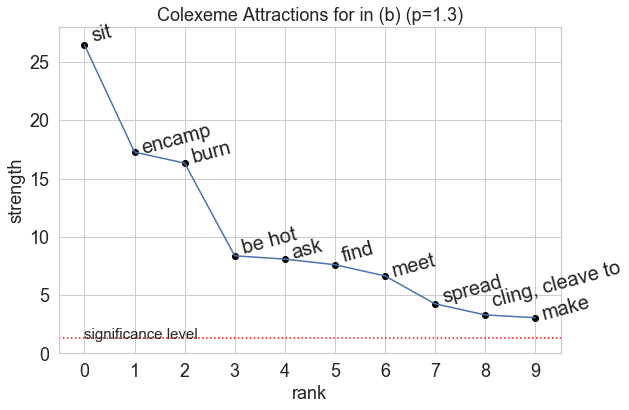

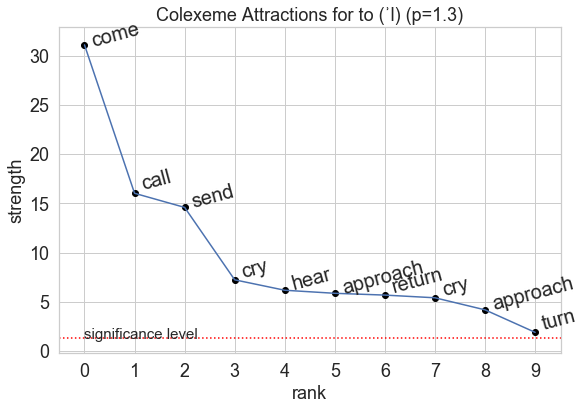

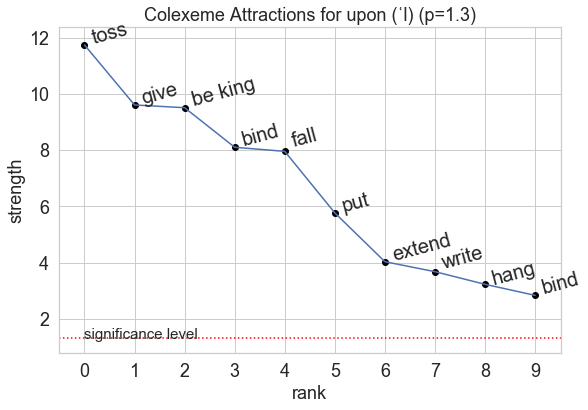

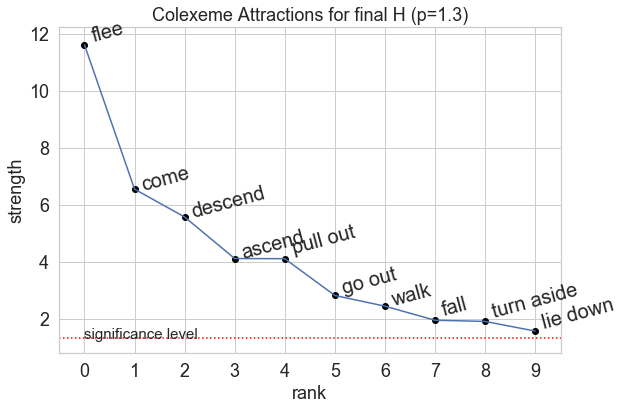

In [62]:
for prep in const_verb_associations.columns:
    
    top_colex = const_verb_associations[prep].sort_values(ascending=False).head(10)
    y = top_colex.values
    x = list(range(0, len(y)))
    labels = getLabel(top_colex, gloss=True)

    plt.figure(figsize=(9, 6))
    plt.plot(x, y)
    plt.axhline(1.3, color='red', linestyle=':')
    plt.scatter(x, y, color='black')
    plt.title(f'Colexeme Attractions for {prep} (p=1.3)', size=18)
    plt.yticks(size=18)
    plt.xticks(range(0, len(top_colex)), size=18)
    plt.xlabel('rank', size=18)
    plt.ylabel('strength', size=18)
    y_axis = plt.gca().get_ylim()[1]-plt.gca().get_ylim()[0]
    for x, y, label in zip(x, y, labels):
        #Plotting text labels: the coordinates of the text are constrained by the scale of the plot as well as the length
        #of the labels, ensuring that the labels do not overlap:
        plt.annotate(label, xy=([x+0.1, y+.8*y_axis/100*len(label)]), size=20, rotation=15)
    plt.annotate('significance level', (0, 1.3), size=15)

### Attraction plots

We move on to plot all verbs and their association strength to the complement constructions. A strong association is visualized by the color red and weak association by the color blue.

In [63]:
def assign_hue(iterable_data, p=1.3, maxvalue=10, minvalue=-10):
    '''
    Function to assign heat-map hues based 
    on a p-value midpoint and max/min attraction
    values.
    
    The following rules are used for making
    the colors:
    p = p-value, i.e. significance level
    upper grey = p
    lower grey = -p
    starting red = p+0.1
    starting blue = -p-0.4
    max_red = max(dataset) if > p = hotmax
    max_blue = min(dataset) if < p = coldmax
    
    --output--
    1. a dataframe with values mapped to a unique color code
    2. a list of rgba colors that are aligned with the
       indices of the data
    '''
    
    maxvalue = int(maxvalue) # for max red
    minvalue = int(minvalue) # for max blue
        
    # assign ranges based on p values and red/blue/grey
    red_range = len(range(int(p), maxvalue+1))
    blue_range = len(range(int(p), abs(minvalue-1)))
        
    blues = sns.light_palette('blue', blue_range)
    reds = sns.light_palette('red', red_range)
    grey = sns.color_palette('Greys')[0]
    
    # assign colors based on p-value
    data = list()
    colorCount = collections.Counter()
    rgbs = list()
    for point in iterable_data:
        if point > p:
            rgb = reds[int(point)-1]
            color = 'red'
        elif point < -p:
            rgb = blues[abs(int(point))-1] 
            color = 'blue'
        else:
            rgb = grey
            color = 'grey'
            
        color_count = colorCount.get(color, 0)
        colorCount[color] += 1
        data.append([point, f'{color}{color_count}'])
        rgbs.append(rgb)
        
    data = pd.DataFrame(data, columns=('value', 'color'))
        
    return data, rgbs

In [64]:
# values for uniform hue assignment:
maxattraction = float(const_verb_associations.max().max())
minattraction = float(const_verb_associations.min().min())
pvalue = 1.3

def plot_attraction(prep, gloss=True):
        
    colexs = const_verb_associations[prep].sort_values()
    colex_data, colors = assign_hue(colexs.values, p=pvalue, maxvalue=maxattraction, minvalue=minattraction)
    
    # plot the figures
    plt.figure(figsize=(15, 4))
    dummyY = ['']*colexs.shape[0] # needed due to bug with Y & hue
    ax = sns.swarmplot(x=colex_data['value'], y=dummyY, hue=colex_data['color'], size=20, palette=colors)
    ax.legend_.remove()
        
    offsetX, offsetY = np.array(ax.collections[0].get_offsets()).T
    
    plt.xlabel('attraction')
    plt.title(f'Attractions to {prep}')
    
    for i, prep in enumerate(colexs.index):  
        annotateX = offsetX[i]
        annotateY = offsetY[i] - 0.06
        if gloss:
            prep_text = prep[:prep.index('_')]
        else:
            prep_text = prep[prep.index('_')+1:]
        if colexs[prep] > pvalue:
            ax.annotate(prep_text, (annotateX, annotateY), size=18)
        elif colexs[prep] < -pvalue:
            ax.annotate(prep_text, (annotateX, annotateY), size=18)

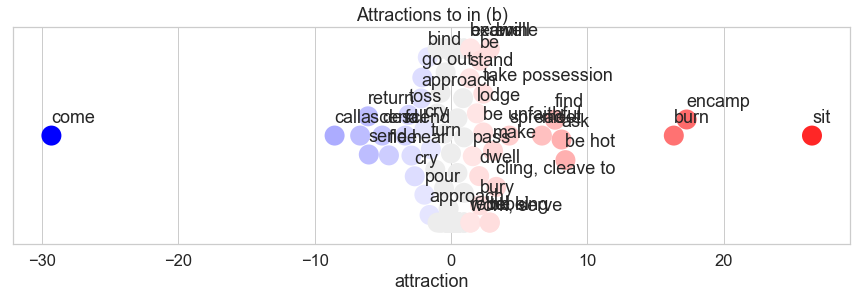

In [65]:
plot_attraction('in (b)')

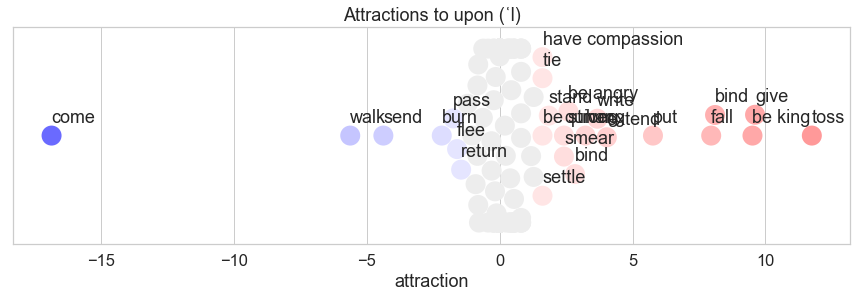

In [66]:
plot_attraction('upon (ʿl)')

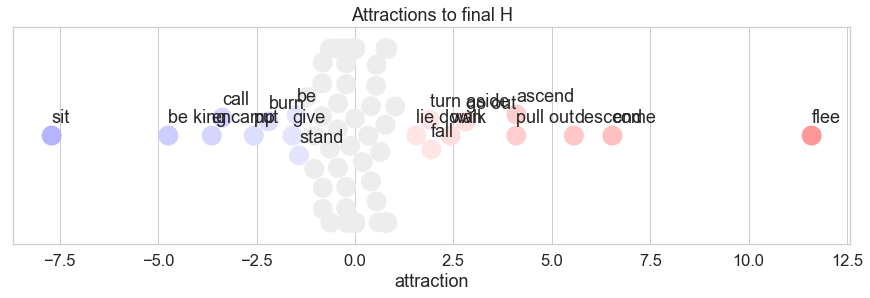

In [67]:
plot_attraction('final H')

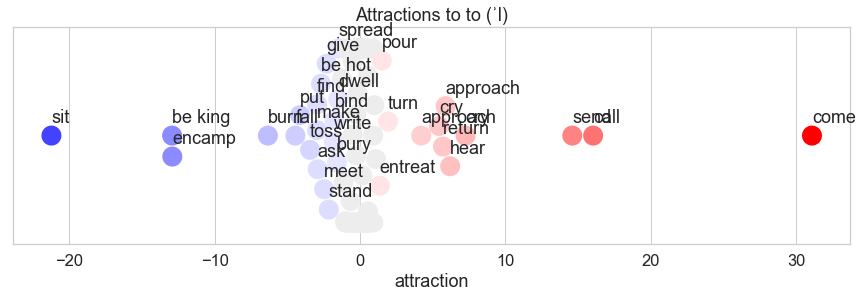

In [68]:
plot_attraction('to (ʾl)')

The plots show a significant contrast between the stative "in" (b) and the directional "to" (*ʾl*), most clearly illustrated by the verbs "sit" and "come", both of which are situated at the extremes of the plots but in mutual opposition. "sit" is very strongly associated with "in" but weakly assocated with "to". "Come" is weakly associated with "in" but strongly associated with "to".

## Principal Component Analysis

We have four thus far plotted the verbs against four different complement constructions. We can combine the association strength data using Principal Component Analysis (PCA) which is designed to reduce the variation of two or more variables to a low number of dimensions.

In [69]:
#Number of principal components:
pc = 4

In [70]:
pca = PCA(pc)
principalComponents = pca.fit(const_verb_associations.iloc[:,0:pc])
pca_transformed = principalComponents.transform(const_verb_associations.iloc[:,0:pc])

### Explained variance

We can visualize the explained variance by a screeplot. As can be seen below, 92.81% of the variance can be explained by two principal components:

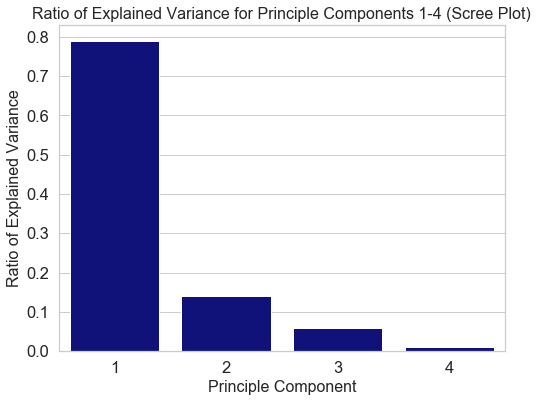

In [71]:
plt.figure(figsize=(8, 6))
sns.barplot(x=np.arange(pc)+1, y=principalComponents.explained_variance_ratio_[:pc], color='darkblue')
plt.xlabel('Principle Component', size=16)
plt.ylabel('Ratio of Explained Variance', size=16)
plt.title(f'Ratio of Explained Variance for Principle Components 1-{pc} (Scree Plot)', size=16)
plt.show()

In [72]:
expl_variance = sum(principalComponents.explained_variance_ratio_[:2])
print(f'Explained variance of two first principlec components: {round(expl_variance*100, 2)}%')

Explained variance of two first principlec components: 93.12%


### Variables

In [73]:
pca_var_fit = pca.fit(const_verb_associations.iloc[:,0:5].T.values)
pca_var = pca_var_fit.transform(const_verb_associations.iloc[:,0:5].T.values)

In [74]:
col_names = [f'PC {n}' for n in range(1,pc+1)] #Column names are computed on the basis of number of principal components

pca_var = pd.DataFrame(data=pca_var, columns = col_names)
pca_var.index = const_verb_associations.columns
pca_var

,PC 1,PC 2,PC 3,PC 4
in (b),-48.976934,-16.206618,-2.733485,1.243450e-14
to (ʾl),50.410494,-9.130609,-8.390838,-1.154632e-14
upon (ʿl),-14.091098,24.456531,-5.544285,-4.218847e-14
final H,12.657538,0.880696,16.668608,4.130030e-14


### Individuals

In [75]:
pca_ind = pd.DataFrame(data = pca_transformed, columns = col_names)

pca_ind.head()

,PC 1,PC 2,PC 3,PC 4
0,-0.045219,-0.355084,0.029944,0.140005
1,-0.012112,0.396801,0.069833,0.271768
2,0.113153,0.541811,-0.142384,0.027686
3,-0.783055,-0.201041,0.088707,0.032446
4,5.801701,-1.156269,-2.563262,-0.819152


In [76]:
pca_ind['lex'] = const_verb_associations.index

In [77]:
pca_ind.head()

,PC 1,PC 2,PC 3,PC 4,lex
0,-0.045219,-0.355084,0.029944,0.140005,<uncertain>_FWX[
1,-0.012112,0.396801,0.069833,0.271768,abandon_NVC[
2,0.113153,0.541811,-0.142384,0.027686,account_XCB[
3,-0.783055,-0.201041,0.088707,0.032446,answer_<NH[
4,5.801701,-1.156269,-2.563262,-0.819152,approach_NGC[


In [83]:
pca_ind

,PC 1,PC 2,PC 3,PC 4,lex
0,-0.045219,-0.355084,0.029944,0.140005,<uncertain>_FWX[
1,-0.012112,0.396801,0.069833,0.271768,abandon_NVC[
2,0.113153,0.541811,-0.142384,0.027686,account_XCB[
3,-0.783055,-0.201041,0.088707,0.032446,answer_<NH[
4,5.801701,-1.156269,-2.563262,-0.819152,approach_NGC[
5,4.140452,-0.768799,-2.147218,-0.308896,approach_QRB[
6,-0.176768,0.097570,-0.187657,0.208433,arise_QWM[
7,0.099324,1.004225,-0.440067,0.039861,arrange_<RK[
8,6.268503,3.055652,4.151711,0.766485,ascend_<LH[
9,-7.213732,-4.299364,-0.494107,-1.122901,ask_C>L[


### Plotting

In [79]:
def annotation(labels, x, y, zoom, gloss):
    noun_xy = {} # for noun_dict
        
    for i, noun in enumerate(labels):
        
        label = labels[i]
        if '_' in label:
            if gloss:
                label = label[:label.index('_')]
            else:
                label = label[label.index('_')+1:]
        
        noun_x, noun_y = x[i], y[i]
        if zoom: # to avoid annotating outside of field of view (makes plot small)
            if any([noun_x < zoom[0], noun_x > zoom[1], noun_y < zoom[2], noun_y > zoom[3]]):                
                continue # skip noun      
           
        #Some lexemes share the same gloss. To disambiguate similar glosses (but different lexemes), a number is added. 
        if label in noun_xy:
            n=2
            new_label = f'{label}#{n}'
            while new_label in noun_xy:
                new_label = f'{label}#{n}'
                n+=1
            label = new_label
            
        noun_xy[label] = (noun_x, noun_y) #Adding to dictionary
    
    return noun_xy

def plot_PCA(dim1=1,
             dim2=2,
             zoom=tuple(), 
             save=False, 
             title='', 
             var_anno=True,
             var_components=pd.DataFrame(),
             var_anno_size='18',
             var_gloss=True,
             ind_anno=True,
             ind_components=pd.DataFrame([]),
             ind_anno_size='18',
             ind_gloss=True,
             color=pd.DataFrame(),
             ellipsis = False,
             label = False
            ):
    '''
    Plots a PCA noun space.
    Function is useful for presenting various zooms on the data.
    '''
    
    #The PC-dimensions are aligned with columns (dimension 1 = column 0, etc.)
    dim1 -= 1
    dim2 -= 1

    # plot coordinates
    f, ax = plt.subplots(1,1,figsize=(15,15))
    
    if zoom:
        xmin, xmax, ymin, ymax = zoom
        plt.xlim(xmin, xmax)
        plt.ylim(ymin, ymax)

    if title:
        plt.title(title, size=18)
        
    if not var_components.empty:
        plt.xlabel(var_components.columns[dim1], size=18)
        plt.ylabel(var_components.columns[dim2], size=18)
    else:
        plt.xlabel(ind_components.columns[dim1], size=18)
        plt.ylabel(ind_components.columns[dim2], size=18)  
    
    plt.axhline(color='red', linestyle=':')
    plt.axvline(color='red', linestyle=':')
    
    # annotate variables:
    if not var_components.empty:
        plt.scatter(var_components.iloc[:,dim1], var_components.iloc[:,dim2], s=50, color='black')
        
        if var_anno:
            var_annotate = annotation(var_components.index, var_components.iloc[:,dim1], var_components.iloc[:,dim2], zoom, var_gloss)
            for n in var_annotate:
                plt.annotate(n, var_annotate[n], size=var_anno_size)

    # annotate individuals:
    if not ind_components.empty:
        if not color.empty:
            
            #Merging individuals dataframe and vowel-pattern dataframe:
            combined_df = pd.merge(ind_components, color, on='lex', how="left")
            combined_df['color'] = combined_df.iloc[:,-1]
            
            for color in set(combined_df.evaluation):
                df_color = combined_df[combined_df.evaluation == color]
                plt.scatter(df_color.iloc[:,dim1], df_color.iloc[:,dim2], label=color)
            
            handles, labels = ax.get_legend_handles_labels()
            ax.legend(handles[1:], labels[1:])
            
        else:
            plt.scatter(ind_components.iloc[:,dim1], ind_components.iloc[:,dim2], s=50, c='lightgrey', alpha=.6)
        
        if ind_anno:
            ind_annotate = annotation(ind_components.lex, ind_components.iloc[:,dim1], ind_components.iloc[:,dim2], zoom, ind_gloss)
            for n in ind_annotate:
                plt.annotate(n, ind_annotate[n], size=ind_anno_size)
                
    if ellipsis:
        for e in ellipsis:
            x, y, width, height, angle, text = e[0], e[1], e[2], e[3], e[4], e[5]
            e = Ellipse((x, y), width, height, angle, facecolor='none', ec='darkblue', lw=1)
            plt.annotate(text, (x+width/2,y+height/3), color='darkblue', size=18)
            ax.add_artist(e)
                
    if label:
        for l in label:
            x, y, label = l[0], l[1], l[2]
            plt.annotate(label, (x, y), color='darkblue', size=18)
    
    if save:
        plt.savefig(save, dpi=300, bbox_inches='tight')
    
    plt.show()

When we plot the weighted variables of the two first dimensions, we observe that the opposition between "to" and "in" accounts for the biggest variation. In this dataset, the two categories are the prototypical means of expressing location and direction. As can be expected the other categories, "upon" and "final H" are located in between, "final H" closer to "to", and "upon" closer to "in", supporting this axis of directionality.

The variation of the second dimension is much smaller and describes the opposition between primarily "in" and "upon". The reason for this opposition may be that the preposition "upon" can be used for other expressions than just the locative, an issue that might cause variation.

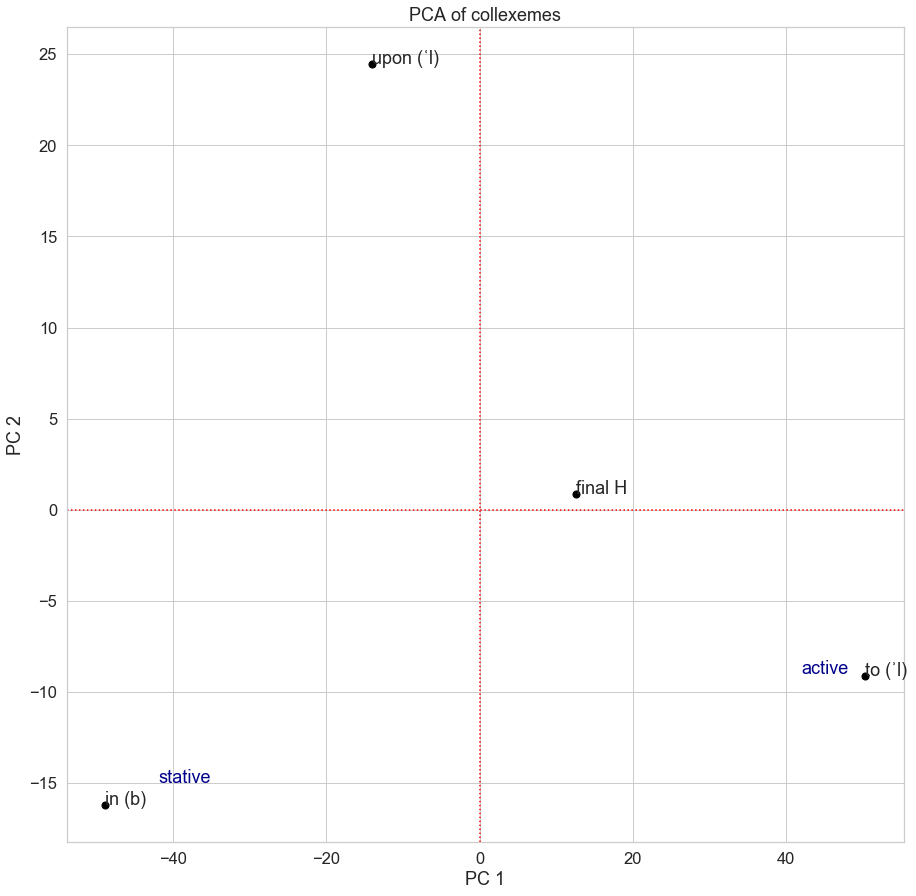

In [80]:
plot_PCA(dim1=1, dim2=2, title='PCA of collexemes', var_components=pca_var, var_gloss=True,
        label=[(-42,-15,'stative'),(42,-9,'active')])

We can plot the individual glosses onto this graph to see how they cluster around the categories:

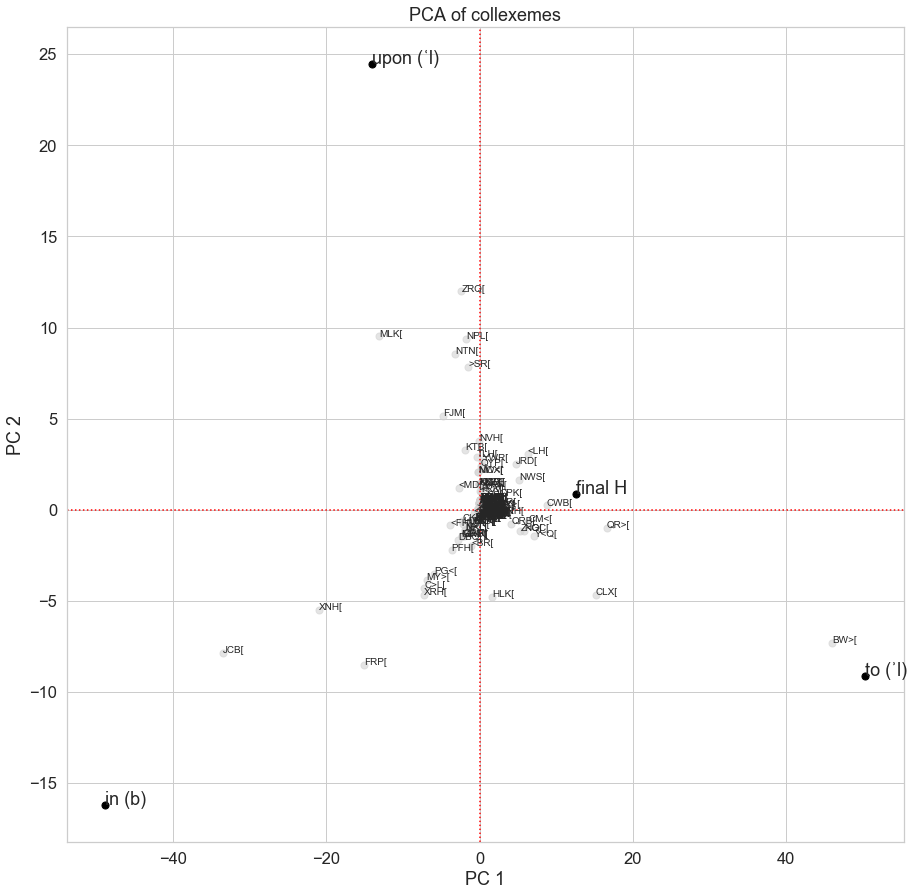

In [82]:
plot_PCA(dim1=1, dim2=2, title='PCA of collexemes', var_components=pca_var,
        ind_components=pca_ind, ind_anno_size=10, ind_anno=True, ind_gloss=False)

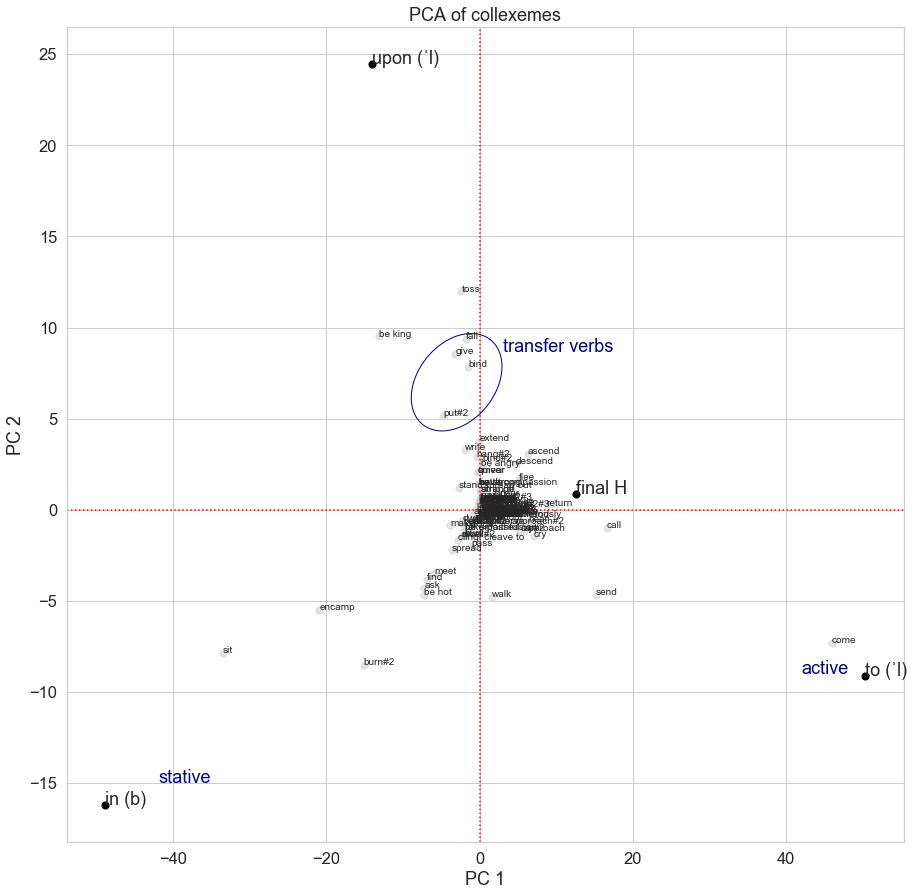

In [295]:
plot_PCA(dim1=1, dim2=2, title='PCA of collexemes', var_components=pca_var, var_gloss=True,
        ind_components=pca_ind, ind_anno_size=10, ind_anno=True, ellipsis=[(-3,7,12,5,10, 'transfer verbs')],
         label=[(-42,-15,'stative'),(42,-9,'active')])

With zoom:

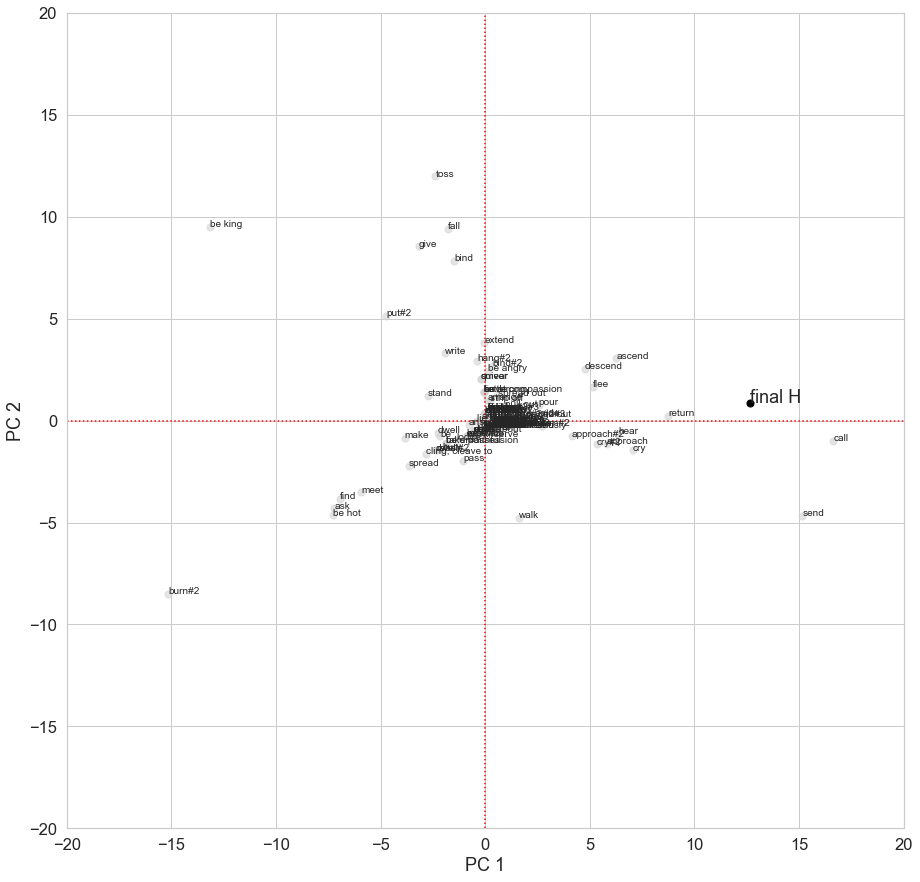

In [296]:
plot_PCA(zoom=(-20,20,-20,20),var_components=pca_var, var_gloss=True,
        ind_components=pca_ind, ind_anno_size=10, ind_anno=True)

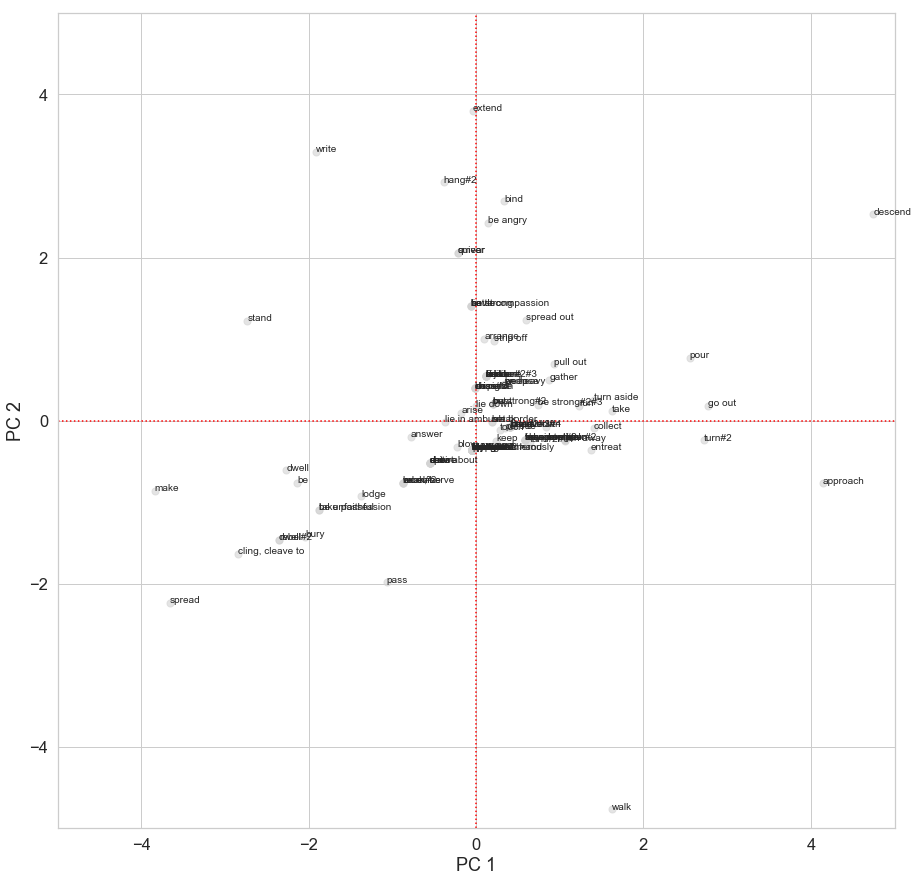

In [297]:
plot_PCA(zoom=(-5,5,-5,5),var_components=pca_var, var_gloss=True,
        ind_components=pca_ind, ind_anno_size=10, ind_anno=True)

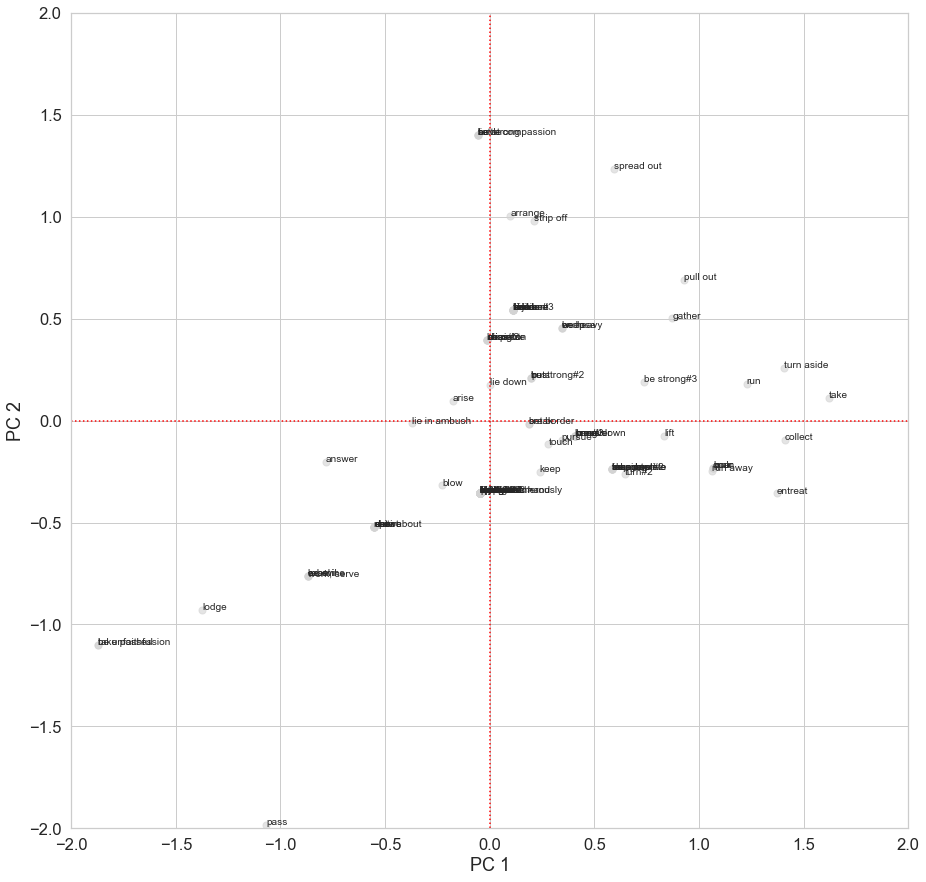

In [303]:
plot_PCA(zoom=(-2,2,-2,2),var_components=pca_var, var_gloss=True,
        ind_components=pca_ind, ind_anno_size=10, ind_anno=True)

### Comparing with vowel patterns

In [169]:
vowel = pd.read_csv('active_stative_verbs.csv')
vowel.columns = ['lex','pattern']

In [170]:
vowel.pattern = vowel.pattern.apply(lambda x: x[:-1])

In [171]:
vowel.head()

,lex,pattern
0,give[,active
1,close[,active
2,rule[,active
3,sit[,active
4,remember[,active


### Top 20 instances:

In [304]:
active = pca_ind.sort_values(by='PC 1', ascending=False)
stative = pca_ind.sort_values(by='PC 1', ascending=True)

In [305]:
stative[:20]

,PC 1,PC 2,PC 3,PC 4,lex
129,-33.570704,-7.858078,-0.940312,2.216321,sit_JCB[
58,-20.926956,-5.476669,0.136156,0.372222,encamp_XNH[
34,-15.138221,-8.503215,-0.957068,-2.304016,burn_FRP[
17,-13.155815,9.519857,-1.121540,4.024244,be king_MLK[
16,-7.250711,-4.653746,-0.744908,-1.191232,be hot_XRH[
9,-7.213732,-4.299364,-0.494107,-1.122901,ask_C>L[
67,-6.924460,-3.849683,-0.286610,-1.089864,find_MY>[
91,-5.936638,-3.523208,-0.339985,-0.833857,meet_PG<[
103,-4.736546,5.150922,-1.993672,0.996153,put_FJM[
89,-3.841236,-0.860984,0.948356,0.315648,make_<FH[


Export to csv:

In [306]:
active[['PC 1','lex']].to_csv('active_stative_verbs_pca.csv')

## Evaluation

The purpose of this section is to evaluate the results of the PCA in light of whether the position in the grid is expected or unexpected/surprising. Intuitively, a verb like "sit" is expected to be stative and that is confirmed by the PCA. Other verbs are positioned in surprising locations.

To evaluate the results, a simple evaluation scheme is applied. The position of the verb can be either: 

* Expected
* Surprising
* Unknown (?)

In [73]:
data = pd.read_csv('active_stative_verbs_pca.csv')

If Principal Component 1 is negative, the verb is assumed to be stative, if positive then active. The expected annotation is added to a separate column:

In [74]:
data['Aktionsart'] = np.where(data['PC 1'] < 0, 'stative', 'active')

In [75]:
data.head()

,Unnamed: 0,PC 1,lex,Aktionsart
0,42,46.010848,come_BW>[,active
1,36,16.635563,call_QR>[,active
2,124,15.153088,send_CLX[,active
3,114,8.747038,return_CWB[,active
4,46,7.058602,cry_Y<Q[,active


In [76]:
len(data)

162

### Evaluating

In [374]:
annotations = 'EXP SUR ?'.split()

STOP = 'stop'
error_message = "Input is invalid"

In [335]:
def input_loop(question, right_answer):
    '''
    input_loop is used when the user is required to make an input. Question has to be a string,
    while right_answer is a list of accepted answer(s).
    '''
    while True:
        test = input(f'{question} ({",".join(right_answer)})') #The user is required to respond to message.
        if test in right_answer:
            return test
        elif test in [STOP]: #Input is accepted
            return test
        else: #Input is wrong and the user has respond again.
            print(error_message)

In [390]:
def user_input(verbs, df=data):
    clear_output()
    answers = {}
    
    for v in verbs:
        
        df_subset = df[df.lex == v]
        lex = df_subset.lex.item()
        Aktionsart = df_subset.Aktionsart.item()

        question = f'Is {lex} {Aktionsart}?'

        user_input = input_loop(question, annotations)

        if user_input == STOP:
            return answers
        else:
            answers[lex] = user_input
    return answers

In [392]:
prev_runs = [run1, run2, run3, run4]

def Verbs(orig_data, prev_runs):

    total_verbs = list(orig_data.lex)
    
    annotated_verbs = []
    remaining_verbs = []
         
    ##1. Check previous runs (dictionaries with annotations)
    for r in prev_runs:
        for verb in r:
            annotated_verbs.append(verb)
            
    ##2. Determine the remaining clauses
    for verb in total_verbs:
        if not verb in annotated_verbs:
            remaining_verbs.append(verb)
    
    return remaining_verbs
        
verbs = Verbs(data,prev_runs)

In [393]:
len(verbs)

0

In [391]:
run4 = user_input(verbs)

Is bind_>SR[ stative? (EXP,SUR,?)?
Is fall_NPL[ stative? (EXP,SUR,?)SUR
Is be unfaithful_M<L[ stative? (EXP,SUR,?)EXP
Is take possession_NXL[ stative? (EXP,SUR,?)SUR
Is write_KTB[ stative? (EXP,SUR,?)SUR
Is bury_QBR[ stative? (EXP,SUR,?)SUR
Is be_HJH[ stative? (EXP,SUR,?)EXP
Is dwell_CKN[ stative? (EXP,SUR,?)EXP
Is dwell_GWR[ stative? (EXP,SUR,?)EXP
Is rebel_MRD[ stative? (EXP,SUR,?)?
Is toss_ZRQ[ stative? (EXP,SUR,?)?
Is stand_<MD[ stative? (EXP,SUR,?)EXP
Is cling, cleave to_DBQ[ stative? (EXP,SUR,?)EXP
Is give_NTN[ stative? (EXP,SUR,?)SUR
Is spread_PFH[ stative? (EXP,SUR,?)?
Is make_<FH[ stative? (EXP,SUR,?)SUR
Is put_FJM[ stative? (EXP,SUR,?)SUR
Is meet_PG<[ stative? (EXP,SUR,?)?
Is find_MY>[ stative? (EXP,SUR,?)SUR
Is ask_C>L[ stative? (EXP,SUR,?)SUR
Is be hot_XRH[ stative? (EXP,SUR,?)EXP
Is be king_MLK[ stative? (EXP,SUR,?)EXP
Is burn_FRP[ stative? (EXP,SUR,?)SUR
Is encamp_XNH[ stative? (EXP,SUR,?)EXP
Is sit_JCB[ stative? (EXP,SUR,?)EXP


### Export evaluation

#### Merge outputs

In [412]:
outputs = [run1, run2, run3, run4]

combined = pd.DataFrame()

for d in outputs:
    d = pd.DataFrame([d]).T
    combined = combined.append(d)
    
len(combined)

162

In [420]:
combined['lex'] = combined.index

In [423]:
new_df = pd.merge(data, combined, on = 'lex', how='left')
new_df

,Unnamed: 0,PC 1,lex,Aktionsart,0
0,42,46.010848,come_BW>[,active,EXP
1,36,16.635563,call_QR>[,active,EXP
2,124,15.153088,send_CLX[,active,EXP
3,114,8.747038,return_CWB[,active,EXP
4,46,7.058602,cry_Y<Q[,active,EXP
5,75,6.368792,hear_CM<[,active,?
6,8,6.268503,ascend_<LH[,active,EXP
7,4,5.801701,approach_NGC[,active,EXP
8,47,5.330829,cry_Z<Q[,active,EXP
9,68,5.133849,flee_NWS[,active,EXP


#### Export to CSV

In [424]:
new_df.to_csv('active_stative_verbs_pca_evaluated.csv')

### Explore difficult/unknown cases

Some cases were difficult to evaluate and I need to explore those further. The cases in question are those marked with '?':

In [4]:
data = pd.read_csv(f'{PATH}active_stative_verbs_pca_evaluated.csv')
data.columns = ['-','-','PC 1', 'lex', 'Aktionsart','evaluation'] 
data.head()

,-,-,PC 1,lex,Aktionsart,evaluation
0,0,42.0,46.010848,come_BW>[,active,EXP
1,1,36.0,16.635563,call_QR>[,active,EXP
2,2,124.0,15.153088,send_CLX[,active,EXP
3,3,114.0,8.747038,return_CWB[,active,EXP
4,4,46.0,7.058602,cry_Y<Q[,active,EXP


In [5]:
unknown_cases = list(data[data.evaluation == '?'].lex)
len(unknown_cases)

59

All comments are collected in a logbook for documentation:

In [66]:
logbook = {}

#### LQX[

In [80]:
unknown_cases[1]

'take_LQX['

In [81]:
def weights(lex, table=const_counts_upd):
    return const_counts_upd[const_counts_upd.index==lex]

In [82]:
weights(unknown_cases[1])

,in (b),to (ʾl),upon (ʿl),final H
take_LQX[,0.0,5.0,1.0,1.0


In [63]:
def display(lex, data=result_test_set, verb_pos = 4):
    lex = lex[lex.index('_')+1:]
    
    clauses = []
    
    for r in data:
        data_lex = F.lex.v(r[verb_pos])
        if data_lex == lex:
            clauses.append(r[1])
    
    for cl in clauses:
        A.pretty(cl)

In [84]:
display(unknown_cases[1])

In [85]:
logbook[unknown_cases[1]] =  '''According to Winther-Nielsen LQX is the opposite of NTN, that is, "cause someone not to
have". In that case it is strange that LQX is not stative like NTN. However, transfer verbs actually combines two events,
the actual transfer event and the resulting state. Here, the directional preposition underscores the causing event'''

The same observations apply to QBY "gather" and >SP "gather"

#### >TR[ "entreat"

In [86]:
unknown_cases[3]

'entreat_<TR['

In [87]:
weights(unknown_cases[3])

,in (b),to (ʾl),upon (ʿl),final H
entreat_<TR[,0.0,3.0,0.0,0.0


In [88]:
display(unknown_cases[2])

In [89]:
logbook[unknown_cases[3]] = '''<TR "entreat" denotes a speach situation and is therefore active'''

#### C<H "look"

In [90]:
unknown_cases[4]

'look_C<H['

In [91]:
weights(unknown_cases[4])

,in (b),to (ʾl),upon (ʿl),final H
look_C<H[,0.0,2.0,0.0,0.0


In [92]:
display(unknown_cases[4])

In [93]:
logbook[unknown_cases[4]] = '''The verb is used in two cases, when Yahweh "looks" to Abels sacrice but not Cains. The
context suggests directed perception, and therefore active'''

#### PYH "open"

In [94]:
unknown_cases[5]

'open_PYH['

In [95]:
weights(unknown_cases[5])

,in (b),to (ʾl),upon (ʿl),final H
open_PYH[,0.0,2.0,0.0,0.0


In [96]:
display(unknown_cases[5])

In [97]:
logbook[unknown_cases[5]] = '''The verb is used with "mouth" as object. It is an activity'''

#### PRF "spread out"

In [98]:
unknown_cases[7]

'spread out_PRF['

In [99]:
weights(unknown_cases[7])

,in (b),to (ʾl),upon (ʿl),final H
spread out_PRF[,0.0,3.0,3.0,0.0


In [100]:
display(unknown_cases[7])

In [101]:
logbook[unknown_cases[7]] = '''Spread out seems to denote an activity, however with and endpoint, that can both be 
towards or upon/over'''

#### MDD "measure"

In [102]:
unknown_cases[8]

'measure_MDD['

In [103]:
weights(unknown_cases[8])

,in (b),to (ʾl),upon (ʿl),final H
measure_MDD[,0.0,1.0,0.0,0.0


In [104]:
display(unknown_cases[8])

In [105]:
logbook[unknown_cases[8]] = '''The verb "measure" clearly involves a direction and is therefore an activity'''

#### LXY "press"

In [106]:
unknown_cases[9]

'press_LXY['

In [107]:
weights(unknown_cases[9])

,in (b),to (ʾl),upon (ʿl),final H
press_LXY[,0.0,0.0,0.0,1.0


In [108]:
display(unknown_cases[9])

In [109]:
logbook[unknown_cases[9]] = '''LXY is used to express push back and is used with a directional. It is an activity'''

#### QDD "kneel down"

In [110]:
unknown_cases[10]

'kneel down_QDD['

In [111]:
display(unknown_cases[10])

In [112]:
logbook[unknown_cases[10]] = '''An activity with an explicit endgoal'''

A similar example is found in GHR[ "crouch"

#### TL> "hang"

In [113]:
unknown_cases[12]

'hang_TL>['

In [114]:
display(unknown_cases[12])

In [115]:
logbook[unknown_cases[12]] = '''The verb is used with a final H as directional or as the place where the bones are hanged.
It is probably a causative event denoting both an inducing event and a resultant state of affairs. We would expect
the verb to be stative.'''

#### GNN "enclose"

In [116]:
unknown_cases[13]

'enclose_GNN['

In [117]:
display(unknown_cases[13])

In [118]:
logbook[unknown_cases[13]] = '''The verb means protect probably protection by surrounding. It is an activity with an
inherent endgoal'''

The verb YWR[ "bind" offers a similar example of enclosure, here negatively stated as sourrounding or besieging

#### CMR "keep"

In [119]:
unknown_cases[15]

'keep_CMR['

In [120]:
display(unknown_cases[15])

In [121]:
logbook[unknown_cases[15]] = '''The literal meaning of CMR is to guard which is an activity. It can also mean to protect 
probably in the sense of causing someone to be safe'''

#### GBL "set border"

In [122]:
unknown_cases[16]

'set border_GBL['

In [123]:
display(unknown_cases[16])

In [124]:
logbook[unknown_cases[16]] = '''The verb may be causative denoting a the positioning of borders. The verb is difficult
however and the second example is also text-critically disputed'''

#### YWM "fast"

In [125]:
unknown_cases[17]

'fast_YWM['

In [126]:
display(unknown_cases[17])

In [127]:
logbook[unknown_cases[17]] = '''While the complement phrase does not denote extension the time phrase denotes extention
of time supporting the results of the analysis'''

#### FRR "rule"

In [128]:
unknown_cases[18]

'rule_FRR['

In [129]:
display(unknown_cases[18])

In [130]:
logbook[unknown_cases[18]] = '''Is probably stative based on the one example'''

#### YB> "serve"

In [131]:
unknown_cases[19]

'serve_YB>['

In [132]:
display(unknown_cases[19])

In [133]:
logbook[unknown_cases[19]] = '''The gloss is not very precise. In the example the verb means war and is an activity'''

#### XYH "divide"

In [134]:
unknown_cases[20]

'divide_XYH['

In [135]:
display(unknown_cases[20])

In [136]:
logbook[unknown_cases[20]] = '''In the example the verb means distribute and is an activity with an inherent endpoint'''

#### PQD "miss"

In [137]:
unknown_cases[21]

'miss_PQD['

In [138]:
display(unknown_cases[21])

In [139]:
logbook[unknown_cases[21]] = '''The verb has many meanings and is difficult to parse. It seems to be an activity'''

#### PWY "disperse"

In [140]:
unknown_cases[22]

'disperse_PWY['

In [141]:
display(unknown_cases[22])

In [142]:
logbook[unknown_cases[22]] = '''The verb seems to be an activity with an inherent endpoint that is to spread out or 
scatter'''

#### RPX "sprout"

In [143]:
unknown_cases[23]

'sprout_PRX['

In [144]:
display(unknown_cases[23])

In [146]:
logbook[unknown_cases[23]] = '''Seems to be activity with an inherent endpoint. The locative denotes the place of the 
activity'''

#### BQ< "split"

In [147]:
unknown_cases[24]

'split_BQ<['

In [148]:
display(unknown_cases[24])

In [149]:
logbook[unknown_cases[24]] = '''The verb probably means to break through or break open that is a causative event with a
stative endpoint'''

#### TPF "seize"

In [150]:
unknown_cases[25]

'seize_TPF['

In [151]:
display(unknown_cases[25])

In [152]:
logbook[unknown_cases[25]] = '''The verb denotes an activiy with an inherent endpoint'''

The same issue pertains to >XZ "seize". The verbs can both be used about the endpoint ("to hold") or about the initial event ("to seize/grasp"). The decomposition is therefore difficult.

#### KL> "restrain"

In [155]:
unknown_cases[27]

'restrain_KL>['

In [156]:
display(unknown_cases[27])

In [157]:
logbook[unknown_cases[27]] = '''It is probably a causative verb meaning keep back or keep imprisoned'''

The next case, <YR "restain", is a similar issue. That verb is used to describe "imprison" or "keep back" or "rule" (= keep within bounds"). I interpret as a causative of a state of being.

In [158]:
display(unknown_cases[28])

#### RGZ "quake" 

In [159]:
unknown_cases[29]

'quake_RGZ['

In [160]:
display(unknown_cases[29])

In [161]:
logbook[unknown_cases[29]] = '''An activity. The locative denotes the place of the activity'''

#### <LY "rejoice"

In [162]:
unknown_cases[30]

'rejoice_<LY['

In [163]:
display(unknown_cases[30])

In [165]:
logbook[unknown_cases[30]] = '''An activity with no inherent endpoint'''

#### PR< "let loose"

In [168]:
unknown_cases[32]

'let loose_PR<['

In [169]:
display(unknown_cases[32])

In [170]:
logbook[unknown_cases[32]] = '''As the gloss suggests the verb is probably inherently causative with an induced stative
situation. In the example the verb is used metaphorically though'''

#### MSR "assign"

In [171]:
unknown_cases[33]

'assign_MSR['

In [172]:
display(unknown_cases[33])

In [173]:
logbook[unknown_cases[33]] = '''The case is text-critically disputed'''

#### JRH= "cast"

In [174]:
unknown_cases[34]

'cast_JRH=['

In [175]:
display(unknown_cases[34])

In [ ]:
logbook[unknown_cases[34]] = '''A causative event with an induced state of being (in the water)'''

#### RJB "contend"

In [177]:
display(unknown_cases[35])

In [ ]:
logbook[unknown_cases[35]] = '''An activity'''

#### VBL "dip"

In [178]:
display(unknown_cases[36])

In [179]:
logbook[unknown_cases[36]] = '''As the example shows the verb denotes an activity that can be repeated multiple times.'''

#### PYR "entreat"

In [181]:
display(unknown_cases[37])

In [182]:
logbook[unknown_cases[37]] = '''An activity'''

#### T<H "err"

In [183]:
display(unknown_cases[38])

In [184]:
logbook[unknown_cases[38]] = '''The verb is probably active but can also be used of a situation (be lost)'''

#### >XZ= "cover"

In [185]:
display(unknown_cases[39])

In [186]:
logbook[unknown_cases[39]] = '''Probably an active verb with an inherent endpoint'''

#### BGD "deal treacherously"

In [187]:
display(unknown_cases[40])

In [188]:
logbook[unknown_cases[40]] = '''The verb is difficult because it can be translated be faithless or act faithlessly cf. the
gloss.'''

#### QWY "loath"

In [64]:
display(unknown_cases[41])

In [67]:
logbook[unknown_cases[41]] = '''The verb denotes a feeling of disgust and is probably stative'''

#### NXH "lead"

In [69]:
display(unknown_cases[42])

In [70]:
logbook[unknown_cases[42]] = '''The verb is probably active - to lead - perhaps a weak causative construction - help me to
walk'''

#### <ZB "leave"

In [72]:
display(unknown_cases[43])

In [73]:
logbook[unknown_cases[43]] = '''The verb is difficult and can refer to the resulting state of being left but also the
active process of leaving something. Perhaps letting something stay'''

#### LQQ "lick"

In [74]:
display(unknown_cases[44])

In [75]:
logbook[unknown_cases[44]] = '''The verb denotes an activity, her with a specific endpoint'''

#### QCR "tie"

In [76]:
display(unknown_cases[45])

In [77]:
logbook[unknown_cases[45]] = '''In these examples the verb means to plot a conspiracy which is an activity'''

#### NW< "quiver"

In [78]:
display(unknown_cases[46])

In [80]:
logbook[unknown_cases[46]] = '''The three examples come from the same context where the verbs probably have a more specific
meaning of dominating. Normally it means to tremble and is clearly an active verb'''

#### TLH "hang"

In [81]:
display(unknown_cases[47])

In [82]:
logbook[unknown_cases[47]] = '''In all examples the verb is transitive with an object to be hanged on something. The verb
is apparently causative and stative'''

#### RMH "shoot"

In [83]:
display(unknown_cases[48])

In [84]:
logbook[unknown_cases[48]] = '''The verb is difficult. It denotes an activity of throwing but is it actually describing
a transfer, thereby causation of changing location?'''

#### MCK "draw"

In [85]:
display(unknown_cases[49])

In [87]:
logbook[unknown_cases[49]] = '''The first example referes to blowing a horn while the other example denotes pulling off
to another location. In both cases, however, the verbs are active'''

#### CWV "rove about"

In [88]:
display(unknown_cases[50])

In [89]:
logbook[unknown_cases[50]] = '''The verb is clearly active and the locative describes the place of the activity'''

#### BXR "examine"

In [90]:
display(unknown_cases[51])

In [91]:
logbook[unknown_cases[51]] = '''The verb means choose in these examples. Choose is an achievement that takes place
instantly. Moreover it is an activity because one can actively choose someone or something.'''

#### PC< "rebel"

In [92]:
display(unknown_cases[52])

In [93]:
logbook[unknown_cases[52]] = '''The verb can mean to rebel or break away but also denote a state of rebellion. The first
example suggest the latter interpretation because one cannot break away for a long period of time. On the other hand
the punctual time phrase in the second example suggests an achievement.'''

#### >SR "bind"

In [94]:
display(unknown_cases[53])

In [96]:
logbook[unknown_cases[53]] = '''The verb denotes an activity but can also be interpreted as a causative in the sense
of confining an object to a place. In the latter sense we should except the presense of locative complements describing
the place of confinement'''

#### MRD "rebel"

In [97]:
display(unknown_cases[54])

In [98]:
logbook[unknown_cases[54]] = '''The presense of punctual time phrases suggests punctual events rather than a stative'''

#### ZRQ "toss"

In [99]:
display(unknown_cases[55])

In [6]:
logbook[unknown_cases[55]] = '''All examples contain complements of the place or direction to be sprinkled/tossed.
Apparently the verb expresses the causation of an object to undergo a movement.'''

NameError: name 'logbook' is not defined

#### PFH "spread"

In [101]:
display(unknown_cases[56])

In [102]:
logbook[unknown_cases[56]] = '''The examples describe accomplishments - become spread. It is a stative verb.'''

#### PG< "meet"

In [103]:
display(unknown_cases[57])

In [105]:
logbook[unknown_cases[57]] = '''An active verb - probably punctual. The locatives describe the place of the event'''

### Statistics of evaluation

In [6]:
eval_updated = pd.read_csv(f'{PATH}active_stative_verbs_pca_evaluated_2.csv', delimiter=';')
eval_updated.columns = ['col1','col2','PC 1','lex','Aktionsart','evaluation','correction']
eval_updated.correction = eval_updated.correction.astype('str')
eval_updated.head()

,col1,col2,PC 1,lex,Aktionsart,evaluation,correction
0,0,42,46.010848,come_BW>[,active,EXP,nan
1,1,36,16.635563,call_QR>[,active,EXP,nan
2,2,124,15.153088,send_CLX[,active,EXP,nan
3,3,114,8.747038,return_CWB[,active,EXP,nan
4,4,46,7.058602,cry_Y<Q[,active,EXP,nan


In [7]:
for row in eval_updated.iterrows():
    row = row[0]
    evaluation = eval_updated['evaluation'][row]
    correction = eval_updated['correction'][row]
    
    if correction != 'nan':
        evaluation = correction
        
    eval_updated['evaluation'][row] = evaluation #Update dataframe

C:\Users\Ejer\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


In [8]:
eval_updated.head()

,col1,col2,PC 1,lex,Aktionsart,evaluation,correction
0,0,42,46.010848,come_BW>[,active,EXP,nan
1,1,36,16.635563,call_QR>[,active,EXP,nan
2,2,124,15.153088,send_CLX[,active,EXP,nan
3,3,114,8.747038,return_CWB[,active,EXP,nan
4,4,46,7.058602,cry_Y<Q[,active,EXP,nan


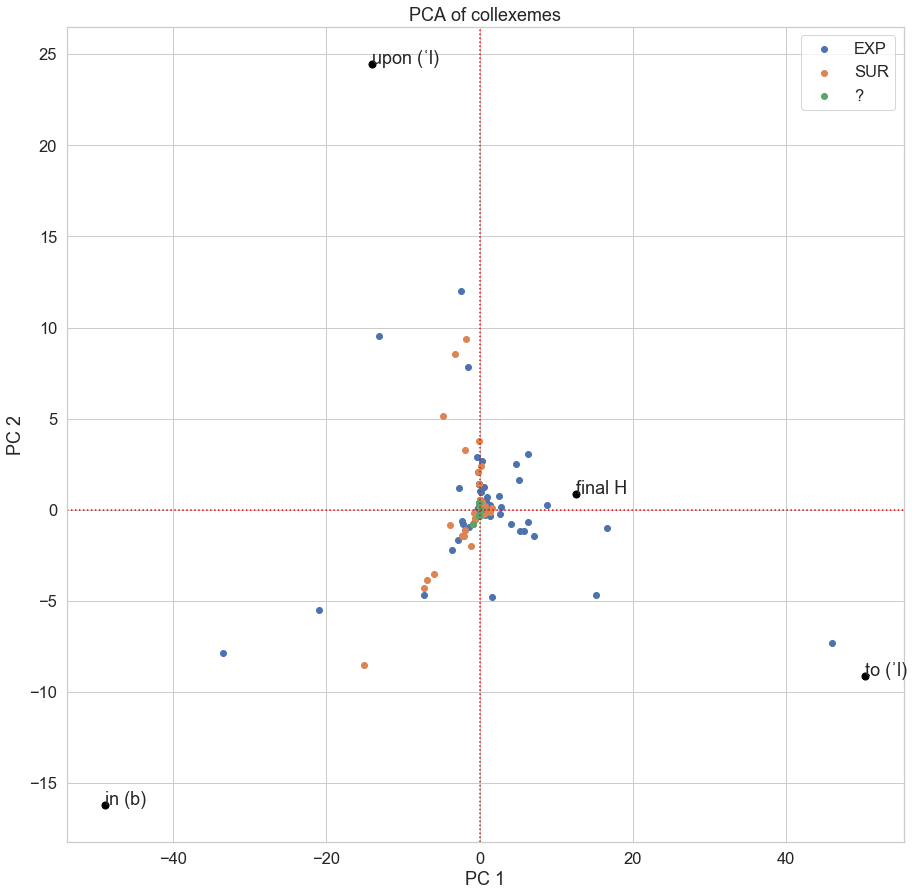

In [153]:
plot_PCA(dim1=1, dim2=2, title='PCA of collexemes', var_components=pca_var,
        ind_components=pca_ind, ind_anno=False, color=eval_updated)

## Exploring surprising cases

In [208]:
sur_df = eval_updated[eval_updated.evaluation == 'SUR']
len(sur_df)

59

In [209]:
sur_df

,col1,col2,PC 1,lex,Aktionsart,evaluation,correction,color
16,16,145.0,1.621983,take_LQX[,active,SUR,SUR,red
17,17,41.0,1.409434,collect_QBY[,active,SUR,SUR,red
28,28,24.0,0.739651,be strong_YLX[,active,SUR,nan,red
35,35,12.0,0.585112,be complete_KLH[,active,SUR,nan,red
42,42,72.0,0.409862,hang_TL>[,active,SUR,SUR,red
44,44,14.0,0.344836,be heavy_KBD[,active,SUR,nan,red
51,51,102.0,0.197555,put_CJT[,active,SUR,nan,red
52,52,23.0,0.197555,be strong_XZQ[,active,SUR,nan,red
53,53,150.0,0.197555,trust_BVX[,active,SUR,nan,red
56,56,11.0,0.143024,be angry_QYP[,active,SUR,nan,red
